In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from crop_cars_utility import *
%matplotlib inline

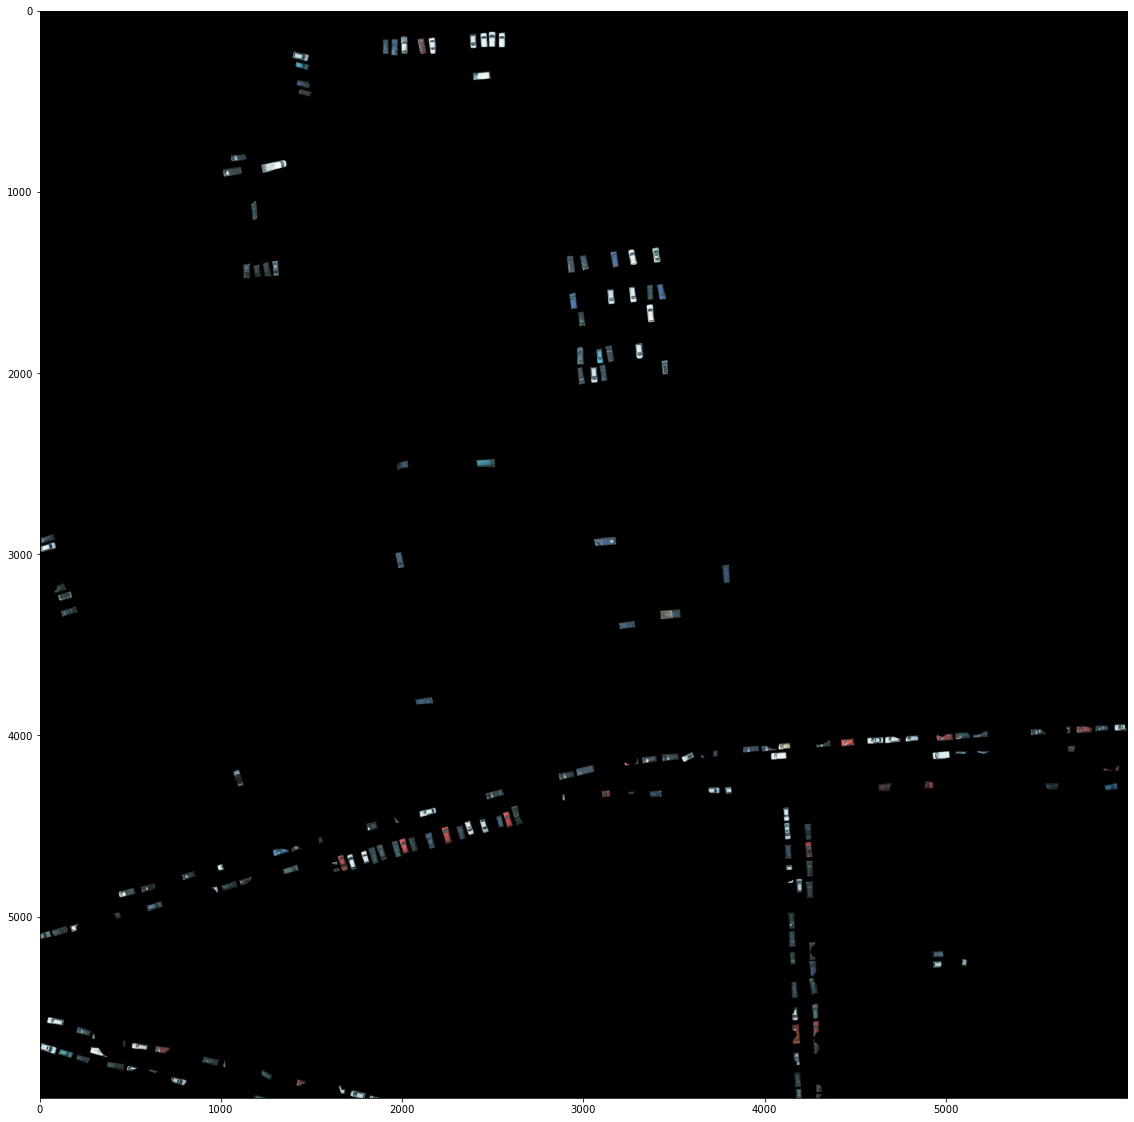

In [2]:
mask = load_images_cv('../data/training/top_potsdam_6_8_label.tif', True)
img = load_images_cv('../data/training/top_potsdam_6_8_RGB.tif', False)
img_filtered = img * mask[:, :, None]
plt.figure(figsize=(20, 20))
plt.imshow(img_filtered)

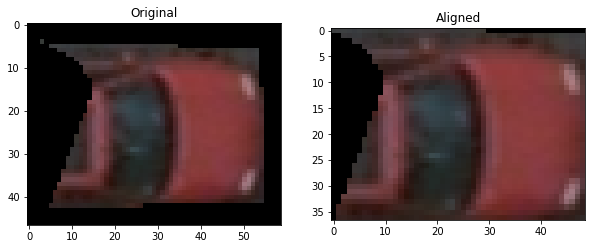

In [82]:
coords = load_cars_bbox_potsdam('../data/training/top_potsdam_6_8_annos.json')
x = coords[100]
buffer = 5

car_original, car_aligned = crop_car(img_filtered, x, buffer)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(car_original)

plt.subplot(1, 2, 2)
plt.title("Aligned")
plt.imshow(car_aligned)

In [83]:
import cv2
mask1 = np.array((car_original[:, :, 0] != 0) &
              (car_original[:, :, 1] != 0) &
              (car_original[:, :, 2] != 0), dtype=np.uint8)
contours, hierarchy = cv2.findContours(mask1, 1, 2)
cnt = contours[0]
hull = cv2.convexHull(cnt)
cv2.isContourConvex(cnt)

False

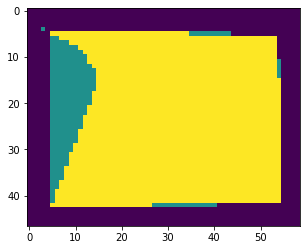

In [84]:
mask2 = np.zeros(car_original.shape[:2], dtype=np.uint8)
mask2 = cv2.drawContours(mask2, [hull], -1, 255, -1)
plt.imshow(mask1 - mask2)

In [61]:
mask2.max(), mask1.max()

(255, 255)

In [34]:
cnt.shape

(52, 1, 2)

15600

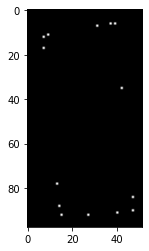

In [44]:
img = np.zeros_like(car_original)
img[cnt[:, 0, 1], cnt[:, 0, 0]] = 100

img.sum()

In [90]:
data_path = "../data/training"
potsdam_cars_succeed, potsdam_cars_failed = return_potsdam_cars(data_path, area_threshold = 0.88)

# succeed cars
if potsdam_cars_succeed:
    cars_path = os.path.join(os.path.split(data_path)[0], "potsdam_cars")
    save_cars(potsdam_cars_succeed, cars_path)

# failed cars
if potsdam_cars_failed:
    cars_path = os.path.join(os.path.split(data_path)[
                             0], "potsdam_cars_failed")
    save_cars(potsdam_cars_failed, cars_path)

::Reading RBG => ../data/training/top_potsdam_6_8_RGB.tif
::Reading Label => ../data/training/top_potsdam_6_8_label.tif
::Reading Annotation => ../data/training/top_potsdam_6_8_annos.json
::Total number of unique cars => 191
--------------------------------------------------
::Reading RBG => ../data/training/top_potsdam_6_10_RGB.tif
::Reading Label => ../data/training/top_potsdam_6_10_label.tif
::Reading Annotation => ../data/training/top_potsdam_6_10_annos.json
::Total number of unique cars => 275
--------------------------------------------------
::Reading RBG => ../data/training/top_potsdam_3_11_RGB.tif
::Reading Label => ../data/training/top_potsdam_3_11_label.tif
::Reading Annotation => ../data/training/top_potsdam_3_11_annos.json
::Total number of unique cars => 167
--------------------------------------------------
::Reading RBG => ../data/training/top_potsdam_7_11_RGB.tif
::Reading Label => ../data/training/top_potsdam_7_11_label.tif
::Reading Annotation => ../data/training/top

In [88]:
area_treshold = 0.88
min_height=20
ratio_threshold=2
carrs = []
for car_aligned in potsdam_cars_failed: 
    r, c, _ = car_aligned.shape
    car_area = np.sum((car_aligned[:, :, 0] != 0) &
                      (car_aligned[:, :, 1] != 0) &
                      (car_aligned[:, :, 2] != 0))
    background_area = r*c
    
    if (r < min_height) or (r == 0 or c == 0) or (c < ratio_threshold*r):
        continue
    if car_area / background_area >= area_treshold:
        carrs.append(car_aligned)
save_cars(carrs, "test")
len(carrs)

463

In [ ]:
json_path = "../data/cem-v0/vehicles_600_carssmalltrucks_outside_bnr10-bnf-defo0.05/annotations.json"
artificial_cars_succeed, artificial_cars_failed = return_artificial_cars(
    json_path, buffer=0, min_height=20, area_threshold=0, ratio_threshold=1)

# succeed cars
if artificial_cars_succeed:
    cars_path = "../data/artificial_cars"
    save_cars(artificial_cars_succeed, cars_path)

# failed cars
if artificial_cars_failed:
    cars_path = "../data/artificial_failed"
    save_cars(artificial_cars_failed, cars_path)